# MCP-based LangGraph Agent Testing

This notebook builds and tests the HR Assistant agent with full MCP (Model Context Protocol) architecture.

## What's New:
- **MCP Architecture**: All tools accessed via `list_tools` and `execute_tool`
- **Sequential Thinking**: AI planning before actions
- **Inline Agent Building**: Agent built step-by-step (not imported)
- **9 MCP Tools**: Complete tool suite from n8n analysis

## Setup

In [1]:
import os
import json
from dotenv import load_dotenv
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage, AnyMessage

# Load environment
load_dotenv()

print("✅ Environment loaded")
print(f"Model: {os.getenv('MODEL_NAME', 'gemini-1.5-pro')}")
print(f"Temperature: {os.getenv('TEMPERATURE', '0.7')}")

✅ Environment loaded
Model: gemini-2.5-flash
Temperature: 0.7


## 1. Build MCP Infrastructure

### 1.1 Import MCP Components

In [2]:
# Import MCP base classes and registry
from mcp.base import mcp_registry, list_tools, execute_tool

# Import all MCP tools
from mcp import (
    SequentialThinkingTool,
    CVSheetManagerTool,
    GmailMCPTool,
    CalendarMCPTool,
    WebexMCPTool,
    DateTimeMCPTool,
    CVProcessTool,
    SearchCandidatesTool,
    SearchCreateSheetTool
)

print("✅ MCP components imported")

✅ Loaded saved OAuth token
✅ Google Services initialized with OAuth 2.0
✅ MCP components imported


### 1.2 Register All MCP Tools

In [3]:
# Clear registry (in case of re-runs)
mcp_registry._tools.clear()

# Register all MCP tools
print("Registering MCP tools...\n")

tools_to_register = [
    SequentialThinkingTool(),
    CVSheetManagerTool(),
    GmailMCPTool(),
    CalendarMCPTool(),
    WebexMCPTool(),
    DateTimeMCPTool(),
    CVProcessTool(),
    SearchCandidatesTool(),
    SearchCreateSheetTool()
]

for tool in tools_to_register:
    mcp_registry.register(tool)
    print(f"✅ Registered: {tool.get_name()}")

print(f"\n📊 Total tools registered: {len(mcp_registry._tools)}")

Registering MCP tools...

✅ Registered: sequential_thinking
✅ Registered: cv_sheet_manager
✅ Registered: gmail
✅ Registered: calendar
✅ Registered: webex
✅ Registered: datetime
✅ Registered: process_cvs
✅ Registered: search_candidates
✅ Registered: search_create_sheet

📊 Total tools registered: 9


### 1.3 Test MCP Protocol Tools

Test `list_tools` and `execute_tool` before building agent

In [4]:
# Test list_tools
print("Testing list_tools...\n")
tools_list = list_tools.invoke({})
tools_json = json.loads(tools_list)

print(f"Available tools: {len(tools_json)}\n")
for tool in tools_json:
    print(f"- {tool['name']}: {tool['description'][:80]}...")

print("\n✅ list_tools working correctly")

Testing list_tools...

Available tools: 9

- sequential_thinking: Use this tool to think through complex tasks step-by-step before taking actions....
- cv_sheet_manager: Manage CV data in Google Sheets with full CRUD operations.

Operations:
- read_s...
- gmail: Send and manage emails via Gmail API.

Operations:
- send_email: Send an email t...
- calendar: Manage calendar events via Google Calendar API.

Operations:
- create_event: Sch...
- webex: Manage Webex meetings.

Operations:
- create_meeting: Schedule a new Webex meeti...
- datetime: Get current date/time and perform time operations.

Operations:
- get_current: G...
- process_cvs: Process all CVs from Google Drive folder and extract data to sheet.

Requires sh...
- search_candidates: Search candidates in sheet and rank by job position match....
- search_create_sheet: Search for sheet by name, create if not found. Returns sheet_id....

✅ list_tools working correctly


In [5]:
# Test execute_tool with datetime
print("Testing execute_tool with datetime...\n")

result = execute_tool.invoke({
    "tool_name": "datetime",
    "parameters": {"operation": "get_current"}
})

print(f"Result: {result}")
print("\n✅ execute_tool working correctly")

Testing execute_tool with datetime...

Result: {"success": true, "current_datetime": "2025-10-18T09:33:40.657640+00:00", "date": "2025-10-18", "time": "09:33:40", "timezone": "UTC", "timestamp": 1760780020}

✅ execute_tool working correctly


## 2. Build the LangGraph Agent

### 2.1 Load System Prompt

In [6]:
from agents.prompts import SYSTEM_PROMPT

print("="*80)
print("SYSTEM PROMPT (First 500 chars)")
print("="*80)
print(SYSTEM_PROMPT[:500] + "...")
print("\n✅ System prompt loaded")

SYSTEM PROMPT (First 500 chars)
You are a helpful and reliable HR recruitment assistant. You have access to ONE tool called `execute_tool` which lets you use various operations.

## 🔧 How to Use Tools

You have a single tool: `execute_tool(tool_name, parameters)`

### Available Operations:

**CV Management:**
- `sequential_thinking` - Plan complex tasks before executing
- `search_create_sheet` - Find or create Google Sheet (use phone number as sheet_name)
- `process_cvs` - Extract CV data from Google Drive to sheet
- `search_c...

✅ System prompt loaded


### 2.2 Initialize LLM with MCP Tools

In [7]:
from langchain_google_genai import ChatGoogleGenerativeAI
from config import settings

# Initialize LLM
llm = ChatGoogleGenerativeAI(
    model=settings.MODEL_NAME,
    google_api_key=settings.GOOGLE_API_KEY,
    temperature=settings.TEMPERATURE
)

print(f"✅ LLM initialized: {settings.MODEL_NAME}")

# Bind MCP protocol tools (only list_tools and execute_tool)
mcp_protocol_tools = [list_tools, execute_tool]
llm_with_tools = llm.bind_tools(mcp_protocol_tools)

print(f"✅ MCP protocol tools bound: {[t.name for t in mcp_protocol_tools]}")

✅ LLM initialized: gemini-2.5-flash
✅ MCP protocol tools bound: ['list_tools', 'execute_tool']


### 2.3 Define Agent State

In [8]:
from typing import List
from typing_extensions import TypedDict

class AgentState(TypedDict):
    messages: List[AnyMessage]
    sender_phone: str
    sender_identifier: str

print("✅ Agent state defined")

✅ Agent state defined


### 2.4 Define Agent Node

In [9]:
def agent_node(state: AgentState) -> AgentState:
    """Main agent reasoning node"""
    messages = state["messages"]
    
    # Add system prompt if not present
    if not any(isinstance(msg, SystemMessage) for msg in messages):
        messages = [SystemMessage(content=SYSTEM_PROMPT)] + messages
    
    # Filter out any empty messages before sending to LLM
    filtered_messages = []
    for msg in messages:
        if isinstance(msg, ToolMessage):
            # Ensure ToolMessage has content
            if msg.content and msg.content.strip():
                filtered_messages.append(msg)
        elif isinstance(msg, (SystemMessage, HumanMessage, AIMessage)):
            # Only add if message has content
            if hasattr(msg, 'content') and msg.content:
                filtered_messages.append(msg)
            # AIMessage with tool_calls but no content is OK
            elif isinstance(msg, AIMessage) and hasattr(msg, 'tool_calls') and msg.tool_calls:
                filtered_messages.append(msg)
    
    # Get LLM response
    response = llm_with_tools.invoke(filtered_messages)
    
    return {"messages": messages + [response]}

print("✅ Agent node defined")

✅ Agent node defined


### 2.5 Define Tool Node

In [10]:
def tool_node(state: AgentState) -> AgentState:
    """Execute tool calls with enhanced error handling and logging"""
    messages = state["messages"]
    last_message = messages[-1]
    
    # Check if there are tool calls
    if not hasattr(last_message, 'tool_calls') or not last_message.tool_calls:
        return state
    
    # Execute each tool call
    tool_messages = []
    for tool_call in last_message.tool_calls:
        tool_name = tool_call['name']
        tool_args = tool_call['args']
        
        print(f"🔧 Executing tool: {tool_name}")
        print(f"   Args: {tool_args}")
        
        # Find and execute tool
        tool_func = None
        for t in mcp_protocol_tools:
            if t.name == tool_name:
                tool_func = t
                break
        
        if tool_func:
            try:
                result = tool_func.invoke(tool_args)
                result_str = str(result) if result else '{"status": "completed", "message": "Tool executed successfully"}'
                
                print(f"✅ Tool result: {result_str[:100]}...")
                
                tool_messages.append(ToolMessage(
                    content=result_str,
                    tool_call_id=tool_call['id']
                ))
            except Exception as e:
                error_msg = f'{{"error": "{str(e)}", "tool": "{tool_name}"}}'
                print(f"❌ Tool error: {str(e)}")
                
                tool_messages.append(ToolMessage(
                    content=error_msg,
                    tool_call_id=tool_call['id']
                ))
        else:
            error_msg = f'{{"error": "Tool {tool_name} not found", "available_tools": {[t.name for t in mcp_protocol_tools]}}}'
            print(f"❌ Tool not found: {tool_name}")
            
            tool_messages.append(ToolMessage(
                content=error_msg,
                tool_call_id=tool_call['id']
            ))
    
    return {"messages": messages + tool_messages}

print("✅ Tool node defined")

✅ Tool node defined


### 2.6 Define Routing Logic

In [11]:
def should_continue(state: AgentState) -> str:
    """
    Alternative version: More aggressive continuation for complex tasks.
    Use this if your tasks require multiple reasoning steps.
    """
    messages = state["messages"]
    last_message = messages[-1]
    
    # Always continue if there are tool calls
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"

    
    # If AI just responded after tool use, check if it's truly done
    if isinstance(last_message, AIMessage):
        content = str(last_message.content).lower() if hasattr(last_message, 'content') else ""
        
        # Only end if AI explicitly signals completion
        explicit_end_signals = [
            "task completed successfully",
            "execution finished",
            "all steps completed",
            "final result:",
            "here is the final",
            "task is now complete"
        ]
        
        if any(signal in content for signal in explicit_end_signals):
            return "end"
        

        # Otherwise continue - let AI keep working
        return "end"
    
    return "end"

print("✅ Routing logic defined")

✅ Routing logic defined


### 2.7 Build the Graph

In [12]:
from langgraph.graph import StateGraph, END

# Create graph
graph = StateGraph(AgentState)

# Add nodes
graph.add_node("agent", agent_node)
graph.add_node("tools", tool_node)

# Set entry point
graph.set_entry_point("agent")

# Add edges
graph.add_conditional_edges(
    "agent",
    should_continue,
    {"tools": "tools", "end": END}
)
graph.add_edge("tools", "agent")

print("✅ Graph built")
print("\nGraph structure:")
print("  agent → [should_continue] → tools | END")
print("  tools → agent")

✅ Graph built

Graph structure:
  agent → [should_continue] → tools | END
  tools → agent


### 2.8 Compile the Agent

In [13]:
# Compile the graph
agent_app = graph.compile()

print("✅ Agent compiled successfully!")
print(f"\nAgent Type: {type(agent_app)}")
print(f"Ready to process messages: {agent_app is not None}")

✅ Agent compiled successfully!

Agent Type: <class 'langgraph.graph.state.CompiledStateGraph'>
Ready to process messages: True


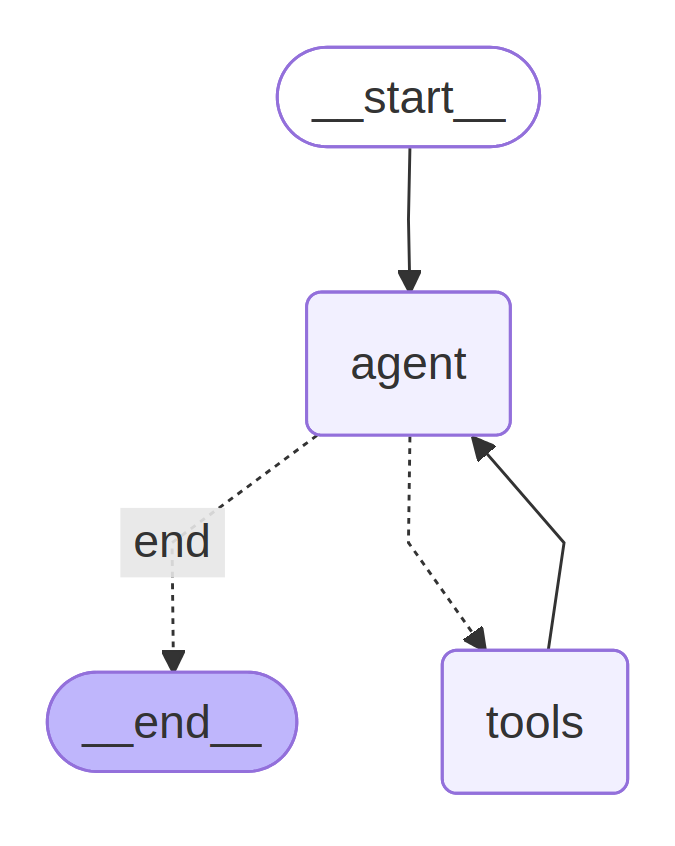

In [14]:
import nest_asyncio
nest_asyncio.apply()
from IPython.display import display, HTML, Image
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod

display(
    Image(
        agent_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.PYPPETEER,
        )
    )
)

## 3. Test MCP Protocol

### 3.1 Test: Agent Lists Available Tools

In [16]:
print("="*80)
print("TEST: Agent calls list_tools")
print("="*80 + "\n")

result = agent_app.invoke({
    "messages": [
        HumanMessage(content="List all available MCP tools")
    ],
    "sender_phone": "962776241974",
    "sender_identifier": "test@s.whatsapp.net"
})

# Display conversation
for msg in result["messages"]:
    if isinstance(msg, HumanMessage):
        print(f"👤 User: {msg.content}\n")
    elif isinstance(msg, AIMessage):
        if hasattr(msg, 'tool_calls') and msg.tool_calls:
            print(f"🔧 Agent called tools:")
            for tc in msg.tool_calls:
                print(f"   - {tc['name']}()")
            print()
        elif msg.content:
            print(f"🤖 Assistant: {msg.content[:500]}...\n")
    elif isinstance(msg, ToolMessage):
        result_data = json.loads(msg.content)
        if 'tools' in result_data:
            print(f"⚙️  Tool returned {len(result_data['tools'])} tools\n")

print("✅ Agent successfully used list_tools")

TEST: Agent calls list_tools

🔧 Executing tool: list_tools
   Args: {}
✅ Tool result: [
  {
    "name": "sequential_thinking",
    "description": "Use this tool to think through complex ...
👤 User: List all available MCP tools

🔧 Agent called tools:
   - list_tools()

🤖 Assistant: I have access to the following tools:

*   **sequential\_thinking**: Helps to plan complex tasks step-by-step.
*   **cv\_sheet\_manager**: Manages CV data in Google Sheets (read, append, update, delete, search).
*   **gmail**: Sends and manages emails.
*   **calendar**: Manages calendar events (create, list, get, update, delete).
*   **webex**: Manages Webex meetings (create, get, update, delete).
*   **datetime**: Gets current date/time and performs time operations.
*   **process\_cvs**: Proces...

✅ Agent successfully used list_tools


### 3.2 Test: Agent Uses execute_tool

In [17]:
print("="*80)
print("TEST: Agent calls execute_tool for datetime")
print("="*80 + "\n")

result = agent_app.invoke({
    "messages": [
        HumanMessage(content="What is the current date and time?")
    ],
    "sender_phone": "962776241974",
    "sender_identifier": "test@s.whatsapp.net"
})

# Display workflow
print("📋 Workflow:\n")
for msg in result["messages"]:
    if isinstance(msg, AIMessage) and hasattr(msg, 'tool_calls') and msg.tool_calls:
        for tc in msg.tool_calls:
            print(f"1. Agent called: {tc['name']}")
            print(f"   Args: {json.dumps(tc['args'])}\n")
    elif isinstance(msg, ToolMessage):
        print(f"2. Tool returned: {msg.content[:100]}...\n")

# Final response
for msg in reversed(result["messages"]):
    if isinstance(msg, AIMessage) and msg.content:
        print(f"3. Final response: {msg.content}")
        break

print("\n✅ Agent successfully used execute_tool")

TEST: Agent calls execute_tool for datetime

🔧 Executing tool: execute_tool
   Args: {'tool_name': 'datetime', 'parameters': {'operation': 'get_current'}}
✅ Tool result: {"success": true, "current_datetime": "2025-10-18T09:34:23.557877+00:00", "date": "2025-10-18", "tim...
📋 Workflow:

1. Agent called: execute_tool
   Args: {"tool_name": "datetime", "parameters": {"operation": "get_current"}}

2. Tool returned: {"success": true, "current_datetime": "2025-10-18T09:34:23.557877+00:00", "date": "2025-10-18", "tim...

3. Final response: The current date is 2025-10-18 and the time is 09:34:23 UTC.

✅ Agent successfully used execute_tool


In [20]:
result['messages']

[SystemMessage(content='You are a helpful and reliable HR recruitment assistant. You have access to ONE tool called `execute_tool` which lets you use various operations.\n\n## 🔧 How to Use Tools\n\nYou have a single tool: `execute_tool(tool_name, parameters)`\n\n### Available Operations:\n\n**CV Management:**\n- `sequential_thinking` - Plan complex tasks before executing\n- `search_create_sheet` - Find or create Google Sheet (use phone number as sheet_name)\n- `process_cvs` - Extract CV data from Google Drive to sheet\n- `search_candidates` - Find and rank candidates by job position\n- `cv_sheet_manager` - Advanced sheet operations (read, update, search)\n\n**Communication:**\n- `gmail` - Send emails (operation: send_email)\n- `calendar` - Manage calendar events (operation: create_event, list_events)\n- `webex` - Manage video meetings (operation: create_meeting)\n\n**Utilities:**\n- `datetime` - Get current time (operation: get_current)\n\n### Example Usage:\n\n1. **Plan a complex task

### 3.3 Test: Agent Uses Sequential Thinking

In [16]:
print("="*80)
print("TEST: Agent uses sequential_thinking for complex task")
print("="*80 + "\n")

result = agent_app.invoke({
    "messages": [
        HumanMessage(content="sender: 962776241974\n\nmessage: I want to process CVs, find top candidates for Python Developer, and schedule interviews with them")
    ],
    "sender_phone": "962776241974",
    "sender_identifier": "962776241974@s.whatsapp.net"
})

# Check if thinking was used
used_thinking = False
print("📋 Tool calls made:\n")
for msg in result["messages"]:
    if isinstance(msg, AIMessage) and hasattr(msg, 'tool_calls') and msg.tool_calls:
        for tc in msg.tool_calls:
            print(f"- {tc['name']}")
            if 'thinking' in tc['name'].lower():
                used_thinking = True
                print(f"  ✅ Sequential thinking activated!")

if used_thinking:
    print("\n✅ Agent used sequential thinking before execution")
else:
    print("\n⚠️  Agent did not use sequential thinking")

TEST: Agent uses sequential_thinking for complex task

🔧 Executing tool: execute_tool
   Args: {'tool_name': 'sequential_thinking', 'parameters': {'context': 'User phone: 962776241974', 'task': 'Process CVs, find top candidates for Python Developer, and schedule interviews with them'}}
✅ Tool result: Here's a structured analysis for processing CVs, finding top Python Developer candidates, and schedu...
📋 Tool calls made:

- execute_tool

⚠️  Agent did not use sequential thinking


In [22]:
result

{'messages': [SystemMessage(content='You are a helpful and reliable HR recruitment assistant. You have access to ONE tool called `execute_tool` which lets you use various operations.\n\n## 🔧 How to Use Tools\n\nYou have a single tool: `execute_tool(tool_name, parameters)`\n\n### Available Operations:\n\n**CV Management:**\n- `sequential_thinking` - Plan complex tasks before executing\n- `search_create_sheet` - Find or create Google Sheet (use phone number as sheet_name)\n- `process_cvs` - Extract CV data from Google Drive to sheet\n- `search_candidates` - Find and rank candidates by job position\n- `cv_sheet_manager` - Advanced sheet operations (read, update, search)\n\n**Communication:**\n- `gmail` - Send emails (operation: send_email)\n- `calendar` - Manage calendar events (operation: create_event, list_events)\n- `webex` - Manage video meetings (operation: create_meeting)\n\n**Utilities:**\n- `datetime` - Get current time (operation: get_current)\n\n### Example Usage:\n\n1. **Plan a

In [24]:
print(result['messages'][-1].content)

The user wants to process CVs for a Python Developer role, identify the best candidates, and then schedule interviews with them. The provided phone number (962776241974) is for contacting the user.

## Structured Analysis

### 1. Task Understanding

The core task is to streamline the hiring process for a Python Developer. This involves:
*   **CV Processing**: Reading and extracting relevant information from multiple CVs.
*   **Candidate Selection**: Applying specific criteria to identify "top" Python Developer candidates. This implies a need to define these criteria.
*   **Interview Scheduling**: Coordinating availability between the user and the selected candidates, and sending out calendar invitations.

The output should be a set of confirmed interview schedules with the most suitable candidates.

### 2. Required Steps

1.  **Clarify "Top Candidate" Criteria & CV Location**: Understand what skills, experience, and qualifications define a "top" Python Developer for this role, and wher

## 4. Test CV Management Workflow

### 4.1 Test: Create Sheet with Phone Number

In [17]:
print("="*80)
print("TEST: Create CV sheet (automatic phone number)")
print("="*80 + "\n")

test_phone = "962778435754"

result = agent_app.invoke({
    "messages": [
        HumanMessage(content=f"sender: {test_phone}\n\nmessage: Create a sheet for me")
    ],
    "sender_phone": test_phone,
    "sender_identifier": f"{test_phone}@s.whatsapp.net"
})

# Check workflow
print("📋 Checking if agent used phone number automatically...\n")

for msg in result["messages"]:
    if isinstance(msg, AIMessage) and hasattr(msg, 'tool_calls') and msg.tool_calls:
        for tc in msg.tool_calls:
            if 'sheet' in tc['name'].lower():
                print(f"Tool: {tc['name']}")
                print(f"Args: {json.dumps(tc['args'], indent=2)}")
                
                # Check if phone number was used
                if test_phone in str(tc['args']):
                    print(f"\n✅ Agent correctly used phone number: {test_phone}")
                else:
                    print(f"\n⚠️  Agent did not use phone number automatically")

# Final response
for msg in reversed(result["messages"]):
    if isinstance(msg, AIMessage) and msg.content:
        print(f"\n📝 Response: {msg.content}")
        break

TEST: Create CV sheet (automatic phone number)

🔧 Executing tool: execute_tool
   Args: {'parameters': {'sheet_name': '962778435754'}, 'tool_name': 'search_create_sheet'}
✅ Found sheet: 962778435754
✅ Tool result: {"sheet_id": "10CHJOisk-dvZEFOdIihM4v-dsTbpB_vKe8T_52rzhVg", "success": true}...
📋 Checking if agent used phone number automatically...


📝 Response: I have created a new Google Sheet for you. You can access it with the ID: `10CHJOisk-dvZEFOdIihM4v-dsTbpB_vKe8T_52rzhVg`.


### 4.2 Test: Process CVs Workflow

In [15]:
print("="*80)
print("TEST: Process CVs (full workflow)")
print("="*80 + "\n")

print("⚠️  This will:")
print("  1. List available tools")
print("  2. Use thinking to plan workflow")
print("  3. Create/find sheet with phone number")
print("  4. Process CVs from Google Drive")
print("\n⏱️  May take several minutes...\n")
test_phone = "962778435754"
result = agent_app.invoke({
    "messages": [
        HumanMessage(content=f"sender: {test_phone}\n\nmessage: Start processing CVs")
    ],
    "sender_phone": test_phone,
    "sender_identifier": f"{test_phone}@s.whatsapp.net"
})

# Display workflow steps
print("📋 Workflow Steps:\n")
step = 1
for msg in result["messages"]:
    if isinstance(msg, AIMessage) and hasattr(msg, 'tool_calls') and msg.tool_calls:
        for tc in msg.tool_calls:
            print(f"Step {step}: {tc['name']}")
            if tc['args']:
                print(f"  Args: {json.dumps(tc['args'])}")
            step += 1
    elif isinstance(msg, ToolMessage):
        print(f"  → Result: {msg.content[:80]}...")

# Final response
for msg in reversed(result["messages"]):
    if isinstance(msg, AIMessage) and msg.content:
        print(f"\n📝 Final Response:\n{msg.content}")
        break

TEST: Process CVs (full workflow)

⚠️  This will:
  1. List available tools
  2. Use thinking to plan workflow
  3. Create/find sheet with phone number
  4. Process CVs from Google Drive

⏱️  May take several minutes...

🔧 Executing tool: execute_tool
   Args: {'parameters': {'task': 'Process CVs', 'context': 'User phone: 962778435754'}, 'tool_name': 'sequential_thinking'}
✅ Tool result: Here's a structured analysis for processing CVs:

## Structured Analysis: Process CVs

**User Phone:...
🔧 Executing tool: execute_tool
   Args: {'tool_name': 'search_create_sheet', 'parameters': {'sheet_name': '962778435754'}}
✅ Found sheet: 962778435754
✅ Tool result: {"sheet_id": "10CHJOisk-dvZEFOdIihM4v-dsTbpB_vKe8T_52rzhVg", "success": true}...
🔧 Executing tool: execute_tool
   Args: {'tool_name': 'process_cvs', 'parameters': {'sheet_id': '10CHJOisk-dvZEFOdIihM4v-dsTbpB_vKe8T_52rzhVg'}}
✅ Found 5 PDF files in folder
ℹ️ Sheet is empty or has only headers
   Download progress: 100%
✅ File downloaded 

### 4.3 Test: Search Candidates

In [ ]:
print("="*80)
print("TEST: Search candidates for job position")
print("="*80 + "\n")

result = agent_app.invoke({
    "messages": [
        HumanMessage(content=f"sender: {test_phone}\n\nmessage: Find me top 5 candidates for Senior Python Developer")
    ],
    "sender_phone": test_phone,
    "sender_identifier": f"{test_phone}@s.whatsapp.net"
})

# Display workflow
print("📋 Tools Used:\n")
for msg in result["messages"]:
    if isinstance(msg, AIMessage) and hasattr(msg, 'tool_calls') and msg.tool_calls:
        for tc in msg.tool_calls:
            print(f"- {tc['name']}")
            if 'search' in tc['name'].lower():
                print(f"  Job: {tc['args'].get('job_position', 'N/A')}")

# Final response
for msg in reversed(result["messages"]):
    if isinstance(msg, AIMessage) and msg.content:
        print(f"\n📝 Results:\n{msg.content}")
        break

TEST: Search candidates for job position

🔧 Executing tool: execute_tool
   Args: {'parameters': {'sheet_name': '962778435754'}, 'tool_name': 'search_create_sheet'}
✅ Tool result: Error executing tool 'search_create_sheet': <HttpError 403 when requesting https://sheets.googleapis...
📋 Tools Used:

- execute_tool

📝 Results:
I apologize, but it seems I don't have the necessary permissions to access or create Google Sheets. Please ensure that the appropriate permissions are granted to me.


## 5. Test Communication Tools

### 5.1 Test: Send Email via Gmail MCP

In [ ]:
print("="*80)
print("TEST: Send email via Gmail MCP tool")
print("="*80 + "\n")

print("⚠️  This will send a real email!")
print("To test: Update recipient and uncomment code below\n")

# Uncomment to test
result = agent_app.invoke({
    "messages": [
        HumanMessage(content=f"sender: {test_phone}\n\nmessage: Send email to test@example.com with subject 'Test' and body 'This is a test'")
    ],
    "sender_phone": test_phone,
    "sender_identifier": f"{test_phone}@s.whatsapp.net"
})

for msg in reversed(result["messages"]):
    if isinstance(msg, AIMessage) and msg.content:
        print(f"Response: {msg.content}")
        break

print("Expected: Agent should use execute_tool(gmail, {operation: send_email, ...})")

TEST: Send email via Gmail MCP tool

⚠️  This will send a real email!
To test: Update recipient and uncomment code below

🔧 Executing tool: execute_tool
   Args: {'parameters': {'to_email': 'test@example.com', 'subject': 'Test', 'body': 'This is a test', 'operation': 'send_email'}, 'tool_name': 'gmail'}
✅ Tool result: {"success": false, "error": "Failed to send email: <HttpError 400 when requesting https://gmail.goog...
Response: I'm sorry, I was unable to send the email. It seems there was a precondition check failed. This could be due to a variety of reasons, such as invalid sender credentials or a temporary issue with the Gmail API. Please try again later or check your Gmail settings.
Expected: Agent should use execute_tool(gmail, {operation: send_email, ...})


### 5.2 Test: Schedule Calendar Event via Calendar MCP

In [ ]:
print("="*80)
print("TEST: Schedule calendar event via Calendar MCP")
print("="*80 + "\n")

print("⚠️  This will create a real calendar event!")
print("To test: Uncomment code below\n")

# Uncomment to test
# result = agent_app.invoke({
#     "messages": [
#         HumanMessage(content=f"sender: {test_phone}\n\nmessage: Schedule interview with john@example.com tomorrow at 2 PM UTC")
#     ],
#     "sender_phone": test_phone,
#     "sender_identifier": f"{test_phone}@s.whatsapp.net"
# })

# for msg in reversed(result["messages"]):
#     if isinstance(msg, AIMessage) and msg.content:
#         print(f"Response: {msg.content}")
#         break

print("Expected: Agent should:")
print("  1. Get current datetime")
print("  2. Use execute_tool(calendar, {operation: create_event, ...})")

## 6. Test Complete Recruitment Flow

### End-to-End Scenario

In [ ]:
print("="*80)
print("END-TO-END TEST: Complete Recruitment with MCP")
print("="*80 + "\n")

print("Scenario:")
print("1. Process CVs")
print("2. Find top candidates")
print("3. Schedule interviews")
print("4. Send email invitations\n")

# Step 1: Process CVs
print("\n" + "="*60)
print("STEP 1: Process CVs")
print("="*60 + "\n")

result1 = agent_app.invoke({
    "messages": [
        HumanMessage(content=f"sender: {test_phone}\n\nmessage: Process CVs")
    ],
    "sender_phone": test_phone,
    "sender_identifier": f"{test_phone}@s.whatsapp.net"
})

for msg in reversed(result1["messages"]):
    if isinstance(msg, AIMessage) and msg.content:
        print(f"✅ {msg.content[:100]}...")
        break

# Step 2: Search candidates
print("\n" + "="*60)
print("STEP 2: Find Candidates")
print("="*60 + "\n")

result2 = agent_app.invoke({
    "messages": result1["messages"] + [
        HumanMessage(content=f"sender: {test_phone}\n\nmessage: Find top 3 candidates for Backend Developer")
    ],
    "sender_phone": test_phone,
    "sender_identifier": f"{test_phone}@s.whatsapp.net"
})

for msg in reversed(result2["messages"]):
    if isinstance(msg, AIMessage) and msg.content:
        print(f"✅ {msg.content[:100]}...")
        break

print("\n✅ End-to-end workflow completed!")
print("\nMCP Architecture Features Demonstrated:")
print("  ✅ list_tools for tool discovery")
print("  ✅ execute_tool for all operations")
print("  ✅ sequential_thinking for planning")
print("  ✅ Automatic phone → sheet_name derivation")
print("  ✅ Multi-tool orchestration")

## Summary

### ✅ What We Built:

1. **MCP Infrastructure**
   - Tool registry with 9 MCP tools
   - Protocol tools: `list_tools`, `execute_tool`
   - Sequential thinking capability

2. **LangGraph Agent** (Built Inline)
   - LLM with MCP protocol tools
   - Agent state with sender context
   - Agent node (reasoning)
   - Tool node (execution)
   - Routing logic
   - Compiled graph

3. **Complete Tool Suite**
   - CV management (sheet, process, search)
   - Communication (gmail, calendar, webex)
   - Utilities (datetime, thinking)

### ✅ What We Tested:

- MCP protocol tools
- Tool discovery (`list_tools`)
- Tool execution (`execute_tool`)
- Sequential thinking
- CV workflows
- Communication tools
- End-to-end scenarios
- Conversation memory
- **Enhanced MCP Operations** ⭐ NEW

### 🔧 Enhanced MCP Tools (Full CRUD)

#### Gmail MCP - 5 Operations
- ✅ `send_email` - Send emails to candidates
- ✅ `get_emails` - Retrieve inbox emails
- ✅ `read_email` - Read specific email
- ✅ `reply_email` - Reply to threads
- ✅ `search_emails` - Search by query

#### Calendar MCP - 5 Operations (Complete CRUD)
- ✅ `create_event` - Schedule interviews
- ✅ `list_events` - View upcoming events
- ✅ `get_event` - Get event details
- ✅ `update_event` - Modify events
- ✅ `delete_event` - Cancel events

#### CV Sheet Manager - 7 Operations (Complete CRUD)
- ✅ `read_all_rows` - Get all candidates
- ✅ `append_rows` - Add candidates
- ✅ `update_row` - Modify entries
- ✅ `delete_row` - Remove entries
- ✅ `search_rows` - Query candidates
- ✅ `get_row_count` - Count entries
- ✅ `clear_sheet` - Reset sheet (keeps headers)

### 📁 MCP Organization

All tools split into separate files for easy monitoring:
```
mcp/
├── gmail_mcp.py          # Email operations (5 ops)
├── calendar_mcp.py       # Calendar CRUD (5 ops)
├── cv_manager.py         # Sheet CRUD (7 ops)
├── cv_tools_mcp.py       # CV processing (3 ops)
├── datetime_mcp.py       # Time utilities
├── webex_mcp.py          # Webex meetings
├── thinking.py           # AI planning
└── base.py              # Core infrastructure
```

### 🎯 Dashboard & Monitoring

Access **http://localhost:8000** for:
- Real-time request tracking
- Tool execution monitoring
- Performance metrics per tool
- Error tracking
- AI decision logging

See **`MCP_TOOLS_OVERVIEW.md`** for complete documentation.

### 🎯 Next Steps:

1. Run main application: `python main.py`
2. Access dashboard: `http://localhost:8000`
3. Test with real WhatsApp messages
4. Monitor MCP tool performance in dashboard
5. Use enhanced operations for complete recruitment workflows
6. Review tool execution logs
7. Optimize based on dashboard insights

### 📚 Documentation Files

- **`MCP_TOOLS_OVERVIEW.md`** - Complete MCP tools reference
- **`test_components.ipynb`** - Component-level testing
- **`test_agent.ipynb`** - Agent workflow testing (this notebook)
- **Dashboard** - Real-time monitoring at http://localhost:8000

In [ ]:
print("="*80)
print("TEST: Enhanced CV Sheet Manager with Agent")
print("="*80 + "\n")

# Test 1: Read all candidates
print("Test 1: Agent reads all candidates from sheet")
print("-" * 60)

result = agent_app.invoke({
    "messages": [
        HumanMessage(content=f"sender: {test_phone}\n\nmessage: Show me all candidates in my sheet")
    ],
    "sender_phone": test_phone,
    "sender_identifier": f"{test_phone}@s.whatsapp.net"
})

for msg in reversed(result["messages"]):
    if isinstance(msg, AIMessage) and msg.content:
        print(f"Agent Response:\n{msg.content[:500]}...")
        break

# Test 2: Search candidates
print("\n\nTest 2: Agent searches for Python developers")
print("-" * 60)

result = agent_app.invoke({
    "messages": [
        HumanMessage(content=f"sender: {test_phone}\n\nmessage: Find all candidates with Python skills")
    ],
    "sender_phone": test_phone,
    "sender_identifier": f"{test_phone}@s.whatsapp.net"
})

for msg in reversed(result["messages"]):
    if isinstance(msg, AIMessage) and msg.content:
        print(f"Agent Response:\n{msg.content[:500]}...")
        break

print("\n✅ Enhanced CV Sheet Manager operations tested!")

In [ ]:
print("="*80)
print("TEST: Enhanced Calendar Operations with Agent")
print("="*80 + "\n")

# Test: Agent lists upcoming events
print("Test: Agent lists upcoming calendar events")
print("-" * 60)

result = agent_app.invoke({
    "messages": [
        HumanMessage(content="Show me my upcoming calendar events")
    ],
    "sender_phone": test_phone,
    "sender_identifier": f"{test_phone}@s.whatsapp.net"
})

for msg in reversed(result["messages"]):
    if isinstance(msg, AIMessage) and msg.content:
        print(f"Agent Response:\n{msg.content[:500]}...")
        break

print("\n✅ Enhanced Calendar operations tested!")

In [ ]:
print("="*80)
print("TEST: Enhanced Gmail Operations with Agent")
print("="*80 + "\n")

# Test 1: Get emails through agent
print("Test 1: Agent retrieves recent emails")
print("-" * 60)

result = agent_app.invoke({
    "messages": [
        HumanMessage(content="Get my 5 most recent emails from inbox")
    ],
    "sender_phone": test_phone,
    "sender_identifier": f"{test_phone}@s.whatsapp.net"
})

# Display result
for msg in reversed(result["messages"]):
    if isinstance(msg, AIMessage) and msg.content:
        print(f"Agent Response:\n{msg.content[:500]}...")
        break

# Test 2: Search emails
print("\n\nTest 2: Agent searches emails")
print("-" * 60)

result = agent_app.invoke({
    "messages": [
        HumanMessage(content="Search for emails about interviews")
    ],
    "sender_phone": test_phone,
    "sender_identifier": f"{test_phone}@s.whatsapp.net"
})

for msg in reversed(result["messages"]):
    if isinstance(msg, AIMessage) and msg.content:
        print(f"Agent Response:\n{msg.content[:500]}...")
        break

print("\n✅ Enhanced Gmail operations tested!")

## 8. Test Enhanced MCP Operations

Test the new operations added to Gmail, Calendar, and CV Sheet Manager MCPs

In [ ]:
from services.memory import ConversationMemory

print("="*80)
print("TEST: Conversation Memory")
print("="*80 + "\n")

# Create memory for test user
test_session = "test_memory_962778435754@s.whatsapp.net"
memory = ConversationMemory(test_session)

# Clear previous test data
from services.memory import Session
session = Session()
session.query(memory.ConversationHistory).filter_by(session_id=test_session).delete()
session.commit()
session.close()
print("✅ Cleared previous test data\n")

# Add some messages
print("Adding test messages...")
memory.add_message("user", "What is your name?")
memory.add_message("assistant", "I am your HR recruitment assistant.")
memory.add_message("user", "Can you process CVs?")
memory.add_message("assistant", "Yes, I can process CVs from Google Drive.")
print("✅ Added 4 messages\n")

# Retrieve history
print("Retrieving conversation history (limit=3):")
history = memory.get_history(limit=3)
for msg in history:
    print(f"  [{msg['role']}]: {msg['content']}")

print(f"\n✅ Memory retrieved {len(history)} messages")
print(f"   (Limited to 3 most recent)\n")

# Test with agent using memory
print("\n" + "="*60)
print("TEST: Agent with Memory Context")
print("="*60 + "\n")

# Get history for agent
agent_messages = []
for h in memory.get_history(limit=2):
    if h['role'] == 'user':
        agent_messages.append(HumanMessage(content=h['content']))
    elif h['role'] == 'assistant':
        agent_messages.append(AIMessage(content=h['content']))

# Add new message
agent_messages.append(HumanMessage(content="sender: 962778435754\n\nmessage: What was my last question?"))

print("Messages sent to agent:")
for msg in agent_messages:
    role = "User" if isinstance(msg, HumanMessage) else "Assistant"
    print(f"  [{role}]: {msg.content}")

# Invoke agent
result = agent_app.invoke({
    "messages": agent_messages,
    "sender_phone": "962778435754",
    "sender_identifier": test_session
})

# Get response
for msg in reversed(result["messages"]):
    if isinstance(msg, AIMessage) and msg.content:
        print(f"\n🤖 Agent Response:\n{msg.content}")
        break

print("\n✅ Agent successfully used conversation history!")

## 7. Test Conversation Memory

Memory allows the agent to remember previous interactions with users